In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

media = [
    'NachDenkSeiten', 
    'taz', 
    'DER SPIEGEL', 
    'ARD', 
    'ZDF', 
    'Bayerischer Rundfunk', 
    'ntv Nachrichten', 
    'faz', 
    'WELT', 
    'BILD', 
    'COMPACTTV'
    ]
parties = [
    'linke',
    'grüne',
    'spd',
    'fdp',
    'cdu',
    'csu',
    'afd'
    ]

In [2]:
def a_pivot_df_medium_vs_party(input_df):
    output_df = pd.pivot_table(input_df, index='medium', columns='party', values='title', aggfunc='count', fill_value=0)
    return output_df

def b_sort_df_by_political_ideology(input_df):
    output_df = input_df.reindex(media)[parties]
    return output_df

def c_standardize_df_by_row_sum(input_df):
    output_df = input_df.div(input_df.sum(axis=1), axis=0)
    return output_df

def d_subtract_df_column_means(input_df):
    output_df = input_df - input_df.mean()
    return output_df
    
def e_heatmap_plot_df(input_df):
    f, ax = plt.subplots(figsize=(9, 8))
    f.subplots_adjust(left=0.15, bottom=.13, right=.99, top=.89)
    sns.heatmap(input_df, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(input_df), cbar=False, cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
    return

def f_saveplot_mentions_short(df, title, path, n_rows_in_title=1):
    from pathlib import Path
    import matplotlib as mpl
    import matplotlib.font_manager as fm
    import matplotlib.pyplot as plt
    mpl.use('pdf')

    fpath = Path(mpl.get_data_path(), "fonts/ttf/cmu_serif_roman.ttf")
    fprop = fm.FontProperties(fname=fpath)

    width = 6.2 #inches
    height = width

    font = {'family':'serif', 'serif': ['cmr10'], 'size':12}
    plt.rc('font',**font)
    plt.rcParams['axes.unicode_minus'] = False
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)


    f, ax = plt.subplots(figsize=(9, 8))
    if n_rows_in_title==1:
        f.subplots_adjust(left=0.14, bottom=.15, right=.99, top=.93)
    elif n_rows_in_title==2:
        f.subplots_adjust(left=0.14, bottom=.15, right=.99, top=.88)
    else:
        return
    
    df_to_plot = df.copy()
    sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(df_to_plot), cbar=False, cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())

    ax.set_xlabel('Party', fontsize=12, font=fpath, color='black')
    ax.set_ylabel('Medium', fontsize=12, font=fpath, color='black')
    ax.set_title(title, fontsize=12, font=fpath, color='black')
    ax.set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black')
    ax.set_yticklabels(['NDS', 'taz', 'Sp', 'ARD', 'ZDF', 'BR', 'ntv', 'faz', 'WELT', 'BILD', 'CTV'], size=12, font=fpath, color='black')

    f.set_size_inches(width, height*11/21)
    f.savefig(path)
    return


In [3]:
party_df = pd.read_pickle('../data/mentions/party_mentions.pkl')
party_df.head()

,medium,id,title,minute,search_term,extracted_string,party
0,ARD,None,studioM - Corona-Demos: Alles Verschwörung?,17,afd,"ist, das zumindest diese Demonstrationen auch ...",afd
1,ARD,None,studioM - Corona-Demos: Alles Verschwörung?,18,die linke,von der AfD. Es gab eine Demonstration von der...,linke
2,ARD,None,studioM - Corona-Demos: Alles Verschwörung?,18,afd,beantworten. Da gab es in Zittau eine Demonstr...,afd
3,ARD,None,studioM - Corona-Demos: Alles Verschwörung?,24,afd,"ich schon für relevant erachte, dass rechtsext...",afd
4,ARD,None,studioM - Corona-Demos: Alles Verschwörung?,31,afd,"Erzählung, die von der rechten Seite, von PEGI...",afd


In [4]:
party_mentions_by_party_df = a_pivot_df_medium_vs_party(party_df)
party_mentions_by_party_df

party,afd,cdu,csu,fdp,grüne,linke,spd
medium,,,,,,,
ARD,293,453,138,427,269,59,574
BILD,1388,6089,2140,3524,1702,550,5589
Bayerischer Rundfunk,99,81,357,97,123,61,265
COMPACTTV,1662,868,276,693,431,271,722
DER SPIEGEL,890,1498,764,1021,592,241,1936
NachDenkSeiten,572,819,313,350,207,461,1551
WELT,1702,9184,3621,6931,3404,1230,9049
ZDF,2510,5030,1576,3938,1880,1114,5016
faz,701,1326,353,799,381,210,1377


In [5]:
ordered_party_mentions_by_party_df = b_sort_df_by_political_ideology(party_mentions_by_party_df)
ordered_party_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,461,207,1551,350,819,313,572
taz,326,507,688,421,712,113,410
DER SPIEGEL,241,592,1936,1021,1498,764,890
ARD,59,269,574,427,453,138,293
ZDF,1114,1880,5016,3938,5030,1576,2510
Bayerischer Rundfunk,61,123,265,97,81,357,99
ntv Nachrichten,366,729,2041,1175,2097,990,831
faz,210,381,1377,799,1326,353,701
WELT,1230,3404,9049,6931,9184,3621,1702


In [6]:
proportion_party_mentions_by_party_df = c_standardize_df_by_row_sum(ordered_party_mentions_by_party_df)
proportion_party_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.107887,0.048444,0.362977,0.081910,0.191669,0.073251,0.133864
taz,0.102613,0.159585,0.216556,0.132515,0.224111,0.035568,0.129053
DER SPIEGEL,0.034716,0.085278,0.278882,0.147076,0.215788,0.110055,0.128205
ARD,0.026661,0.121554,0.259376,0.192951,0.204700,0.062359,0.132399
ZDF,0.052886,0.089252,0.238131,0.186954,0.238796,0.074820,0.119161
Bayerischer Rundfunk,0.056325,0.113573,0.244691,0.089566,0.074792,0.329640,0.091413
ntv Nachrichten,0.044477,0.088589,0.248025,0.142788,0.254830,0.120306,0.100984
faz,0.040800,0.074024,0.267534,0.155236,0.257626,0.068584,0.136196
WELT,0.035022,0.096922,0.257652,0.197346,0.261496,0.103101,0.048461


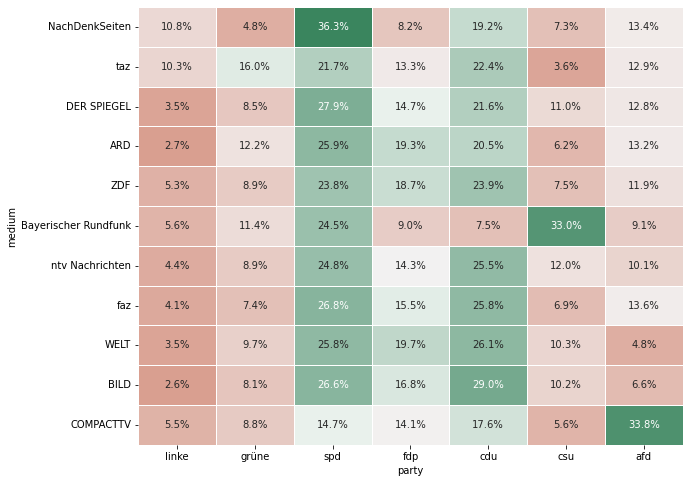

In [7]:
e_heatmap_plot_df(proportion_party_mentions_by_party_df)

In [8]:
deviations_party_mentions_by_party_df = d_subtract_df_column_means(proportion_party_mentions_by_party_df)
deviations_party_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.054919,-0.046637,0.109626,-0.066732,-0.025634,-0.029998,0.004456
taz,0.049645,0.064504,-0.036794,-0.016127,0.006809,-0.067681,-0.000355
DER SPIEGEL,-0.018252,-0.009803,0.025532,-0.001566,-0.001514,0.006806,-0.001203
ARD,-0.026307,0.026474,0.006026,0.044309,-0.012603,-0.040890,0.002992
ZDF,-0.000082,-0.005829,-0.015219,0.038312,0.021494,-0.028429,-0.010247
Bayerischer Rundfunk,0.003357,0.018493,-0.008660,-0.059076,-0.142510,0.226391,-0.037995
ntv Nachrichten,-0.008491,-0.006491,-0.005325,-0.005854,0.037528,0.017057,-0.028424
faz,-0.012167,-0.021057,0.014184,0.006594,0.040324,-0.034665,0.006788
WELT,-0.017946,0.001842,0.004302,0.048704,0.044194,-0.000148,-0.080947


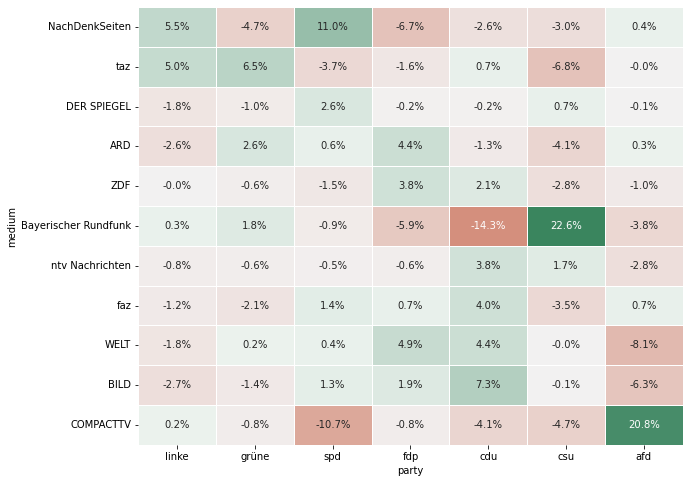

In [9]:
e_heatmap_plot_df(deviations_party_mentions_by_party_df)

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


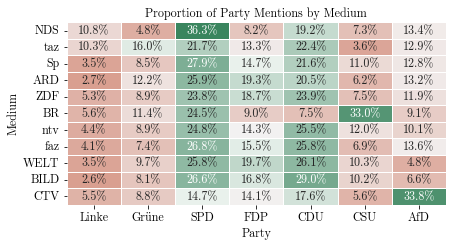

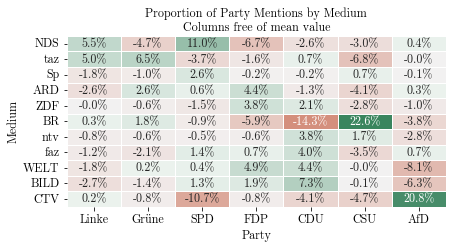

In [10]:
f_saveplot_mentions_short(df=proportion_party_mentions_by_party_df, title='Proportion of Party Mentions by Medium', path='../results/englisch/erwähnungen_partei_gekuerzt.pdf')
f_saveplot_mentions_short(df=deviations_party_mentions_by_party_df, title='Proportion of Party Mentions by Medium\nColumns free of mean value', path='../results/englisch/erwähnungen_partei_gekuerzt_mittelwertfrei.pdf', n_rows_in_title=2)

In [14]:
politician_df = pd.read_pickle('../data/mentions/politician_mentions.pkl')
politician_df.head()

,medium,id,title,minute,search_term,extracted_string,party
0,ARD,None,studioM: Grüne Kompromisse - Hauptsache Macht?,1,lisa badum,diskutieren wir heute natürlich auch mit einer...,grüne
1,ARD,None,studioM: Grüne Kompromisse - Hauptsache Macht?,5,annalena baerbock,"ist. Und es steht außer Frage, dass die Grünen...",grüne
2,ARD,None,studioM: Grüne Kompromisse - Hauptsache Macht?,14,robert habeck,"sein. Auf der Pressekonferenz, wo der Koalitio...",grüne
3,ARD,None,studioM: Grüne Kompromisse - Hauptsache Macht?,25,annalena baerbock,der Außengrenze an der EU-Außengrenze zu rügen...,grüne
4,ARD,None,studioM: Grüne Kompromisse - Hauptsache Macht?,31,paul ziemiak,"so, dass in einigen Bereichen da durchaus Verb...",cdu


In [15]:
politician_df.search_term.value_counts().head(10)

olaf scholz          13114
armin laschet         7175
friedrich merz        4250
annalena baerbock     4040
karl lauterbach       3197
robert habeck         3062
jens spahn            2594
christian lindner     2565
heiko maas             901
norbert röttgen        696
Name: search_term, dtype: int64

In [16]:
politician_mentions_by_party_df = a_pivot_df_medium_vs_party(politician_df)
politician_mentions_by_party_df

party,afd,cdu,csu,fdp,grüne,linke,spd
medium,,,,,,,
ARD,21,296,22,95,183,33,437
BILD,49,5874,302,1409,1885,121,5337
Bayerischer Rundfunk,15,30,32,8,41,8,36
COMPACTTV,62,92,2,27,88,86,123
DER SPIEGEL,56,508,70,201,347,58,526
NachDenkSeiten,13,220,25,28,140,168,361
WELT,89,5786,509,1723,4813,343,9618
ZDF,90,3395,184,695,1432,222,3247
faz,22,441,85,97,307,40,569


In [17]:
ordered_politician_mentions_by_party_df = b_sort_df_by_political_ideology(politician_mentions_by_party_df)
ordered_politician_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,168,140,361,28,220,25,13
taz,55,139,123,40,93,13,7
DER SPIEGEL,58,347,526,201,508,70,56
ARD,33,183,437,95,296,22,21
ZDF,222,1432,3247,695,3395,184,90
Bayerischer Rundfunk,8,41,36,8,30,32,15
ntv Nachrichten,53,413,1112,219,1300,86,55
faz,40,307,569,97,441,85,22
WELT,343,4813,9618,1723,5786,509,89


In [18]:
proportion_politician_mentions_by_party_df = c_standardize_df_by_row_sum(ordered_politician_mentions_by_party_df)
proportion_politician_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.175916,0.146597,0.378010,0.029319,0.230366,0.026178,0.013613
taz,0.117021,0.295745,0.261702,0.085106,0.197872,0.027660,0.014894
DER SPIEGEL,0.032843,0.196489,0.297848,0.113817,0.287656,0.039638,0.031710
ARD,0.030359,0.168353,0.402024,0.087397,0.272309,0.020239,0.019319
ZDF,0.023961,0.154560,0.350459,0.075013,0.366433,0.019860,0.009714
Bayerischer Rundfunk,0.047059,0.241176,0.211765,0.047059,0.176471,0.188235,0.088235
ntv Nachrichten,0.016368,0.127548,0.343422,0.067634,0.401482,0.026560,0.016986
faz,0.025625,0.196669,0.364510,0.062140,0.282511,0.054452,0.014094
WELT,0.014991,0.210349,0.420349,0.075303,0.252874,0.022246,0.003890


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


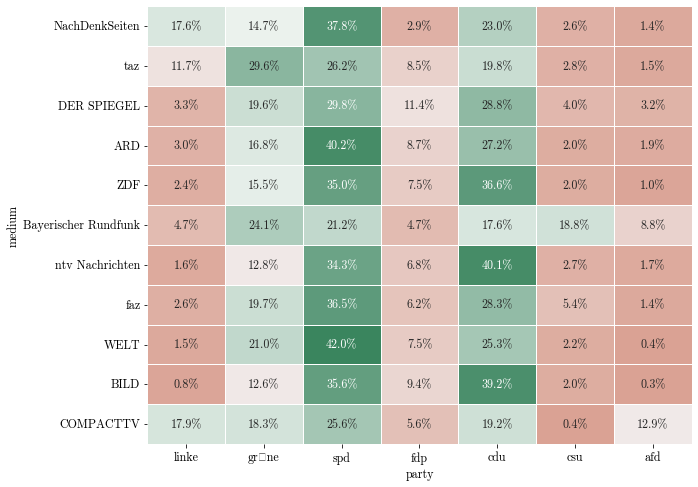

In [19]:
e_heatmap_plot_df(proportion_politician_mentions_by_party_df)

In [20]:
deviations_politician_mentions_by_party_df = d_subtract_df_column_means(proportion_politician_mentions_by_party_df)
deviations_politician_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.114881,-0.039465,0.046857,-0.042782,-0.047074,-0.014676,-0.017741
taz,0.055986,0.109683,-0.069451,0.013005,-0.079568,-0.013195,-0.016460
DER SPIEGEL,-0.028193,0.010427,-0.033305,0.041715,0.010216,-0.001217,0.000356
ARD,-0.030676,-0.017709,0.070871,0.015295,-0.005131,-0.020615,-0.012035
ZDF,-0.037074,-0.031502,0.019306,0.002912,0.088993,-0.020995,-0.021640
Bayerischer Rundfunk,-0.013976,0.055115,-0.119388,-0.025043,-0.100970,0.147381,0.056881
ntv Nachrichten,-0.044667,-0.058514,0.012269,-0.004467,0.124042,-0.014295,-0.014368
faz,-0.035411,0.010607,0.033357,-0.009962,0.005071,0.013598,-0.017260
WELT,-0.046045,0.024287,0.089196,0.003201,-0.024567,-0.018609,-0.027464


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


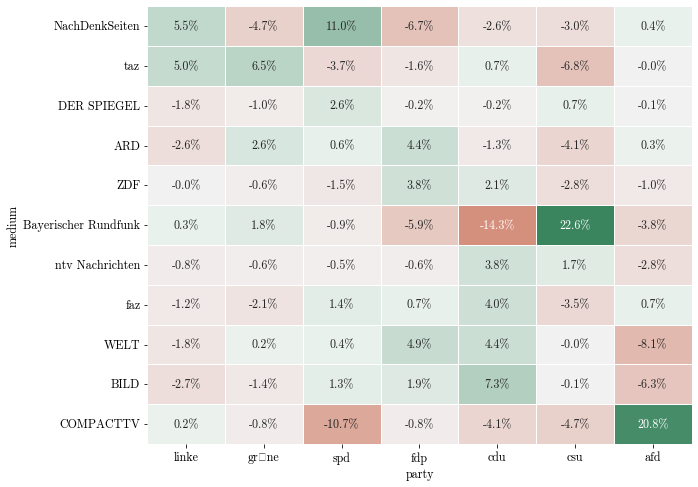

In [21]:
e_heatmap_plot_df(deviations_party_mentions_by_party_df)

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


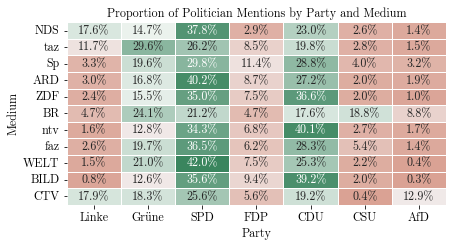

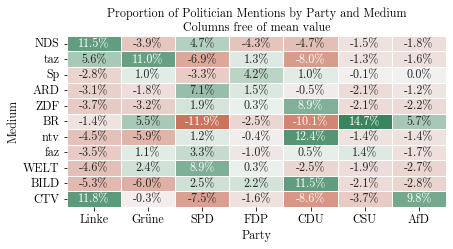

In [22]:
f_saveplot_mentions_short(df=proportion_politician_mentions_by_party_df, title='Proportion of Politician Mentions by Party and Medium', path='../results/englisch/erwähnungen_politiker_gekuerzt.pdf')
f_saveplot_mentions_short(df=deviations_politician_mentions_by_party_df, title='Proportion of Politician Mentions by Party and Medium\nColumns free of mean value', path='../results/englisch/erwähnungen_politiker_gekuerzt_mittelwertfrei.pdf', n_rows_in_title=2)

In [25]:
unique_politician_df = pd.read_pickle('../data/mentions/politician_mentions_unique.pkl')
unique_politician_df.head()

,medium,search_term,mention_count,party
0,WELT,olaf scholz,1057,spd
1,BILD,olaf scholz,766,spd
2,WELT,armin laschet,634,cdu
3,ZDF,olaf scholz,569,spd
4,BILD,armin laschet,485,cdu


In [27]:
unique_politician_mentions_by_party = pd.pivot_table(unique_politician_df, index='medium', columns='party', values='mention_count', aggfunc='sum', fill_value=0)
unique_politician_mentions_by_party

party,afd,cdu,csu,fdp,grüne,linke,spd
medium,,,,,,,
ARD,6,31,8,7,5,2,16
BILD,35,1810,185,641,684,73,1757
Bayerischer Rundfunk,6,19,22,7,25,4,28
COMPACTTV,53,74,2,22,73,61,97
DER SPIEGEL,41,248,38,116,207,46,272
NachDenkSeiten,11,159,22,21,92,114,255
WELT,76,2176,232,665,1178,202,2348
ZDF,67,1136,111,318,614,137,1205
faz,19,375,63,77,236,31,487


In [28]:
ordered_unique_politician_mentions_by_party = b_sort_df_by_political_ideology(unique_politician_mentions_by_party)
ordered_unique_politician_mentions_by_party

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,114,92,255,21,159,22,11
taz,35,77,76,23,61,8,6
DER SPIEGEL,46,207,272,116,248,38,41
ARD,2,5,16,7,31,8,6
ZDF,137,614,1205,318,1136,111,67
Bayerischer Rundfunk,4,25,28,7,19,22,6
ntv Nachrichten,41,212,492,138,528,54,40
faz,31,236,487,77,375,63,19
WELT,202,1178,2348,665,2176,232,76


In [29]:
proportion_unique_politician_mentions_by_party_df = c_standardize_df_by_row_sum(ordered_unique_politician_mentions_by_party)
proportion_unique_politician_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.169139,0.136499,0.378338,0.031157,0.235905,0.032641,0.016320
taz,0.122378,0.269231,0.265734,0.080420,0.213287,0.027972,0.020979
DER SPIEGEL,0.047521,0.213843,0.280992,0.119835,0.256198,0.039256,0.042355
ARD,0.026667,0.066667,0.213333,0.093333,0.413333,0.106667,0.080000
ZDF,0.038183,0.171126,0.335842,0.088629,0.316611,0.030936,0.018673
Bayerischer Rundfunk,0.036036,0.225225,0.252252,0.063063,0.171171,0.198198,0.054054
ntv Nachrichten,0.027243,0.140864,0.326910,0.091694,0.350831,0.035880,0.026578
faz,0.024068,0.183230,0.378106,0.059783,0.291149,0.048913,0.014752
WELT,0.029373,0.171296,0.341428,0.096699,0.316417,0.033736,0.011051


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


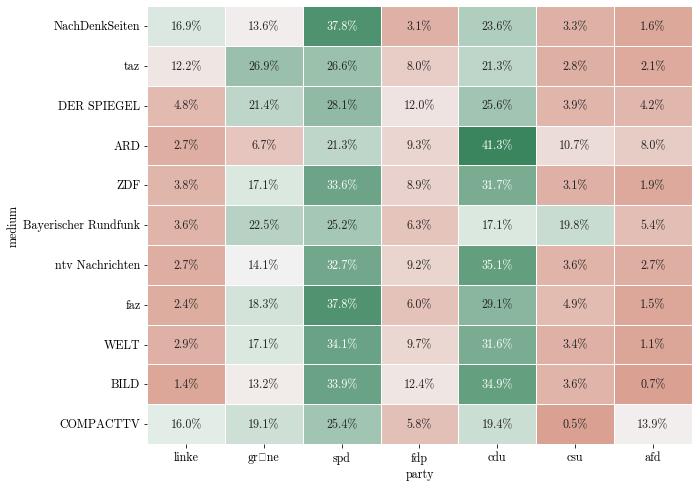

In [30]:
e_heatmap_plot_df(proportion_unique_politician_mentions_by_party_df)

In [31]:
deviations_unique_politician_mentions_by_party_df = d_subtract_df_column_means(proportion_unique_politician_mentions_by_party_df)
deviations_unique_politician_mentions_by_party_df

party,linke,grüne,spd,fdp,cdu,csu,afd
medium,,,,,,,
NachDenkSeiten,0.106015,-0.036319,0.072363,-0.051191,-0.046613,-0.021460,-0.022794
taz,0.059253,0.096413,-0.040241,-0.001929,-0.069232,-0.026129,-0.018135
DER SPIEGEL,-0.015604,0.041025,-0.024983,0.037487,-0.026320,-0.014845,0.003241
ARD,-0.036458,-0.106151,-0.092642,0.010985,0.130815,0.052565,0.040886
ZDF,-0.024942,-0.001692,0.029867,0.006281,0.034092,-0.023165,-0.020441
Bayerischer Rundfunk,-0.027089,0.052407,-0.053723,-0.019285,-0.111347,0.144097,0.014940
ntv Nachrichten,-0.035882,-0.031954,0.020935,0.009346,0.068312,-0.018221,-0.012536
faz,-0.039056,0.010412,0.072131,-0.022566,0.008631,-0.005188,-0.024363
WELT,-0.033751,-0.001522,0.035453,0.014351,0.033899,-0.020366,-0.028063


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:18: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


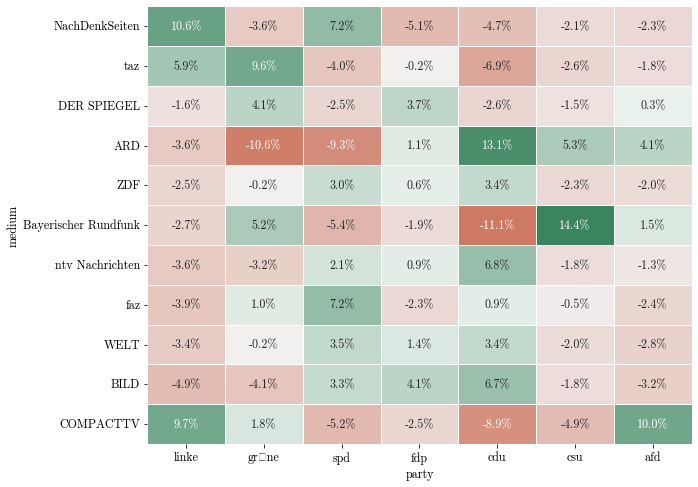

In [32]:
e_heatmap_plot_df(deviations_unique_politician_mentions_by_party_df)

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()
/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_39092/4203351164.py:44: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


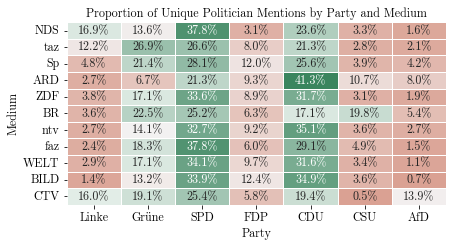

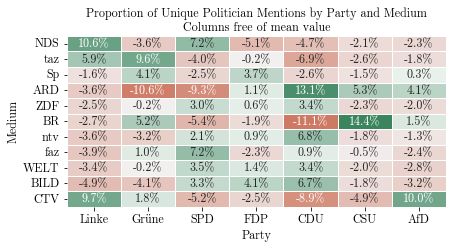

In [33]:
f_saveplot_mentions_short(df=proportion_unique_politician_mentions_by_party_df, title='Proportion of Unique Politician Mentions by Party and Medium', path='../results/englisch/erwähnungen_politiker_gekuerzt_einzigartig.pdf')
f_saveplot_mentions_short(df=deviations_unique_politician_mentions_by_party_df, title='Proportion of Unique Politician Mentions by Party and Medium\nColumns free of mean value', path='../results/englisch/erwähnungen_politiker_gekuerzt_mittelwertfrei_einzigartig.pdf', n_rows_in_title=2)